In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from sklearn.impute import SimpleImputer
from src.data.datasets import get_dataset
from src.models.networks import get_mlp
from src.utils import one_hot

In [2]:
df_reset = pd.read_csv("../reports/adaptive_schedules/v7.csv.zip")
df_reset = df_reset[
    ~df_reset["resetter"].isin(
        ["P-KSWIN_1", "P-KSWIN_0.5", "P-KSWIN_0.125", "P-KSWIN_0.0625"]
    )
]
df_reset = df_reset.rename(columns={"resetter": "schedule"})
df_rm = agg_dataframe(df_reset, ['base_lr', 'gamma', 'dataset', 'schedule'])
best_params = get_best_params(df_rm, params=["base_lr", "gamma"], fixed_params=['dataset', 'schedule'], metric='accuracy_mean')
df_rb = best_params.merge(df_reset, on=['base_lr', 'gamma', 'dataset', 'schedule'])

In [3]:
x, y = get_dataset("Insects abrupt")
y = one_hot(y)
x_sample, y_sample = x[0], y[0]
net = get_mlp(x_sample.shape[-1], y_sample.shape[-1])
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [4]:
df_rb["optimizer"] = "SGD"
df_rb["schedule"] = df_rb["schedule"].replace(
    {
        "P-KSWIN_0.25": "Exp. Soft Reset",
        "OneTailedADWIN": "Exp. Reset",
        "ADWIN Weight Reset": "Exp. Weight Reset",
    }
)
df_optims = pd.read_csv("../reports/effective_lrs/v1.csv.zip")
df_optims = df_optims[df_optims["schedule"] != "Exponential reset"]
df_optims.loc[:, 'lr_norm'] /= np.sqrt(n_params)
df = pd.concat([df_rb, df_optims])
df["loss"] = df["loss"].clip(upper=df["loss"].quantile(0.995))

In [5]:
df["schedule"] = df["schedule"].replace({"Exponential": "Exp.", "Exponential reset": "Exp. Reset"})
df["accuracy"] *= 100

In [6]:
dfm = agg_dataframe(df, cols_to_keep=["dataset", "optimizer", "step", 'schedule'])
dfm['schedule'] = dfm['schedule'].apply(lambda x: x.title())

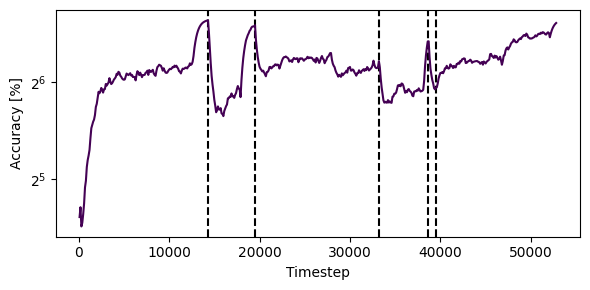

In [7]:
# Make Plot for Insects abrupt dataset
schedules = [
    # "Exp.",
    # "Exp. Reset",
    "Fixed",
]
base_schedules = [schedule.strip(" Reset") for schedule in schedules]

dfp = dfm[
    (dfm["dataset"] == "Insects abrupt")
    & (dfm["optimizer"] == "SGD")
    & (dfm["schedule"].isin(schedules))
]
change_points = [14352, 19500, 33240, 38682, 39510]
metrics = ["accuracy_mean"]
names = ["Accuracy [%]"]

cmapper = ValueColorMapper(values=schedules)
fig, axs = plt.subplots(nrows=1, figsize=(6, 3), sharex=True)
axs = [axs]
for row_idx, metric in enumerate(metrics):
    ax = axs[row_idx] 
    for change_point in change_points:
        ax.axvline(change_point, color="black", linestyle="dashed")
    for schedule, dfs in dfp.groupby("schedule"):
        base_schedule = schedule.strip(" Reset")
        color = cmapper(schedule)
        ax.plot(
            dfs["step"],
            dfs[metric].ewm(alpha=0.2).mean(),
            c=color,
            label=schedule,
        )

for ax, name in zip(axs, names):
    ax.set_ylabel(name)
ax.set_yscale("log", base=2)
# axs[1].legend()
ax.set_xlabel("Timestep")
fig.tight_layout()
plt.savefig("../pub/figures/sgd_insects_abrupt.pdf")

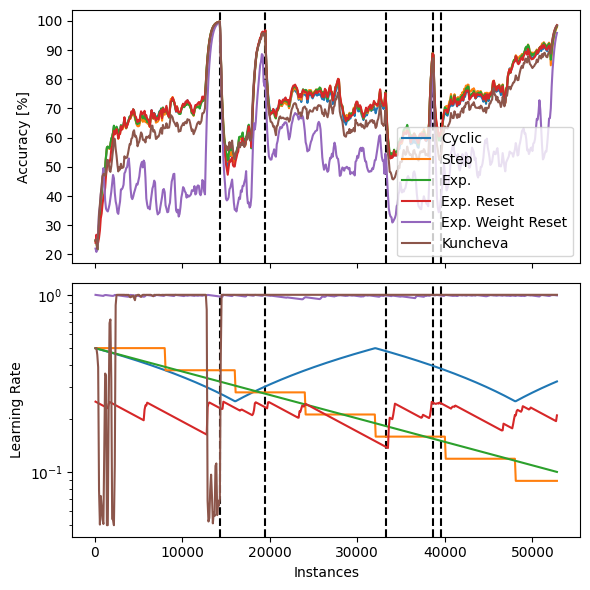

In [11]:
# Make Plot for Insects abrupt dataset
dfp = dfm.copy()
optimizers = [
    "SGD",
]
schedules = [
    "Cyclic",
    "Step",
    "Exp.",
    "Exp. Reset",
    "Exp. Weight Reset",
    "Kuncheva",
]

dfp['schedule'] = pd.Categorical(dfp['schedule'], categories=schedules, ordered=True)

# Sort the DataFrame using the custom ordering
dfp = dfp.sort_values(by='schedule')

dfp = dfp[
    (dfp["dataset"] == "Insects abrupt")
    & (dfp["optimizer"].isin(optimizers))
    & (dfp["schedule"].isin(schedules))
]
change_points = [14352, 19500, 33240, 38682, 39510]
metrics = ["accuracy_mean", "lr_mean"]
names = ["Accuracy [%]", "Learning Rate"]
n_rows = len(metrics)

cmapper = ValueColorMapper(values=dfp["schedule"].unique())
fig, axs = plt.subplots(nrows=n_rows, figsize=(6, 3*n_rows), sharex=True)
for row_idx, metric in enumerate(metrics):
    ax = axs[row_idx]
    for change_point in change_points:
        ax.axvline(change_point, color="black", linestyle="dashed")
    for schedule, dfs in dfp.groupby("schedule"):
        dfs = dfs.sort_values(by='step')
        color = cmapper(schedule)
        if metric != 'lr_mean':
            ys = dfs[metric].ewm(alpha=0.25).mean()
        else:
            ys = dfs[metric]
        ax.plot(
            dfs["step"],
            ys,
            # c=color,
            label=schedule,
        )

for ax, name in zip(axs, names):
    ax.set_ylabel(name)
ax
ax.set_yscale("log")
# ax.set_ylim([0.5, 1e7])
axs[0].legend()
ax.set_xlabel("Instances")
fig.tight_layout()
plt.savefig("../pub/figures/lr_norms_schedules_insects_abrupt.pdf")

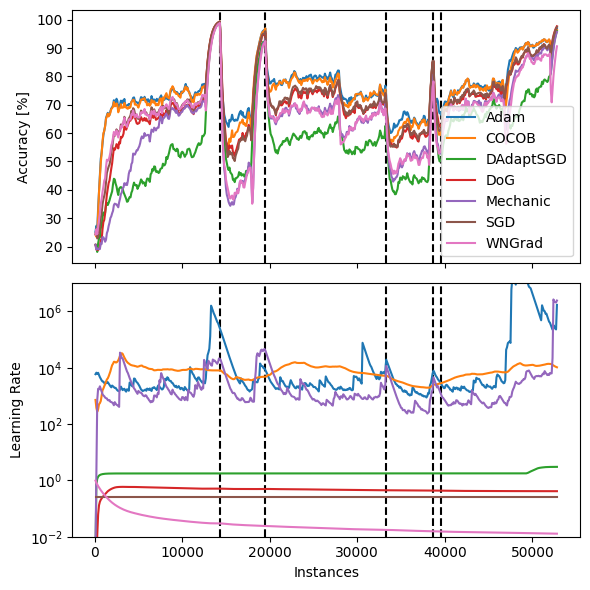

In [13]:
# Make Plot for Insects abrupt dataset
dfp = dfm.copy()
optims = dfp["optimizer"] + " " + dfp["schedule"]
dfp["optimizer"] = optims.apply(lambda x: x.replace(" Fixed", ""))

optimizers = [
    "SGD",
    "Adam",
    # "Adam Reset",
    # "SGD Exp. Reset",
    "COCOB",
    "WNGrad",
    "DAdaptSGD",
    "DoG",
    # "AdaGrad",
    "Mechanic",
]

dfp = dfp[(dfp["dataset"] == "Insects abrupt") & (dfp["optimizer"].isin(optimizers))]
change_points = [14352, 19500, 33240, 38682, 39510]
metrics = ["accuracy_mean", "lr_norm_mean"]
names = ["Accuracy [%]", "Learning Rate"]
n_rows = len(metrics)

cmapper = ValueColorMapper(values=dfp["optimizer"].unique())
fig, axs = plt.subplots(nrows=n_rows, figsize=(6, 3 * n_rows), sharex=True)
for row_idx, metric in enumerate(metrics):
    ax = axs[row_idx]
    for change_point in change_points:
        ax.axvline(change_point, color="black", linestyle="dashed")
    for schedule, dfs in dfp.groupby("optimizer"):
        color = cmapper(schedule)
        ax.plot(
            dfs["step"],
            dfs[metric].ewm(alpha=0.2).mean(),
            # c=color,
            label=schedule,
        )

for ax, name in zip(axs, names):
    ax.set_ylabel(name)
ax.set_yscale("log")
ax.set_ylim([1e-2, 1e7])
axs[0].legend()
ax.set_xlabel("Instances")
fig.tight_layout()
plt.savefig("../pub/figures/lr_norms_optims_insects_abrupt.pdf")